In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_notebook
sys.path.append('../../reproducible_figures/scripts/')
import rep_fig_vis as rfv
sys.path.append('../scripts/')
from loadpaths_glc import loadpaths
import data_loading_utils as dlu
import glc_prediction_utils as gpu
path_dict = loadpaths()

In [36]:
dict_dfs, dict_dfs_species, dict_val_species = dlu.load_metadata(create_geo=True, add_h3=False,
                                               create_validation_set=True)
# type(dict_dfs['df_test_pa'])

Dropped PO data because takes ages with geometry
Columns dropped: ['taxonRank', 'geoUncertaintyInM', 'date', 'areaInM2', 'publisher', 'month', 'day', 'region', 'dayOfYear', 'country']
Dropped 49637/1483637 duplicates in df_train_pa_species
Created validation set with 8898 entries


In [39]:
val_or_test = 'test'

dict_dfs, dict_dfs_species, dict_val_species = dlu.load_metadata(create_geo=True, add_h3=False,
                                create_validation_set=True if val_or_test == 'val' else False)
tmp = gpu.predict_using_buffer(dict_dfs=dict_dfs, dict_dfs_species=dict_dfs_species,
                            save_pred=True, method=f'lc-specific', buffer_deg=0.3,
                            eval_mode=val_or_test)
if val_or_test == 'val':
    f1_score = gpu.compute_f1_score_dicts(dict_val_species, tmp)
    print(f'F1 score: {f1_score}')

Dropped PO data because takes ages with geometry
Columns dropped: ['taxonRank', 'geoUncertaintyInM', 'date', 'areaInM2', 'publisher', 'month', 'day', 'region', 'dayOfYear', 'country']
Dropped 49637/1483637 duplicates in df_train_pa_species
    LandCover  count
0         0.0     25
1         1.0     15
2         2.0     18
3         4.0     22
4         5.0     16
5         8.0     20
6         9.0     16
7        10.0     19
8        11.0     14
9        12.0     17
10       13.0     16
11       14.0     17
12       15.0     11
13       16.0     12
14       17.0     13


 43%|████▎     | 2049/4716 [00:13<00:17, 149.13it/s]

No nearby points for surveyId: 1695841 (LC: 13.0)


100%|██████████| 4716/4716 [00:31<00:00, 151.01it/s]

Predictions done (4715 total). No nearby points: 1.
Saved predictions to: /Users/t.vanderplas/data_offline/data_geolifeclef2024/predictions_glc2024/GLC24_vdplasthijs_predictions-buffer-lc-0.3-lc-specific_2024-04-18_22-53.csv


In [32]:
tmp

,lng,lat,year,surveyId,geometry,Elevation,LandCover,Bio1,Bio2,Bio3,...,Bio10,Bio11,Bio12,Bio13,Bio14,Bio15,Bio16,Bio17,Bio18,Bio19
26108,8.46318,56.02289,2017,1276701,POINT (8.46318 56.02289),19.0,5.0,2816,43,2,...,2884,2754,9632,1247,429,280,3286,1651,2340,2355
67032,8.37565,56.17565,2017,3288416,POINT (8.37565 56.17565),12.0,5.0,2818,35,1,...,2884,2757,9171,1203,406,288,3162,1557,2557,1995
26071,8.44744,56.15897,2019,1274470,POINT (8.44744 56.15897),28.0,5.0,2816,41,2,...,2884,2754,9733,1261,438,279,3318,1673,2703,2368
34794,8.44535,56.15905,2019,1702631,POINT (8.44535 56.15905),28.0,5.0,2816,41,2,...,2884,2754,9733,1261,438,279,3318,1673,2703,2368
34735,8.44792,56.15915,2019,1699855,POINT (8.44792 56.15915),29.0,5.0,2816,41,2,...,2884,2754,9733,1261,438,279,3318,1673,2703,2368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10850,8.59644,56.29672,2019,530563,POINT (8.59644 56.29672),22.0,5.0,2815,53,2,...,2886,2750,9560,1209,452,259,3191,1682,2323,2364
57771,8.58748,56.29928,2019,2842242,POINT (8.58748 56.29928),23.0,5.0,2815,52,2,...,2886,2750,9539,1208,450,260,3188,1677,2317,2357
7138,8.58928,56.34263,2019,349859,POINT (8.58928 56.34263),33.0,5.0,2815,54,2,...,2886,2750,9326,1181,442,260,3118,1638,2264,2306
31530,8.59174,56.34313,2019,1539083,POINT (8.59174 56.34313),27.0,5.0,2815,54,2,...,2886,2750,9335,1181,443,259,3117,1642,2266,2310


## Predictions

In [53]:
(df_train, df_test), (df_train_species, df_val_species) = dlu.create_full_pa_ds(val_or_test='test')

Columns dropped: ['taxonRank', 'geoUncertaintyInM', 'date', 'areaInM2', 'publisher', 'month', 'day', 'region', 'dayOfYear', 'country']
Dropped 49637/1483637 duplicates in df_train_pa_species
Dropped 135101/5079797 duplicates in df_train_po_species


In [59]:
df_train_species

,speciesId,surveyId
0,6874,212
1,476,212
2,11157,212
3,8784,212
4,4530,212
...,...,...
1483632,53,3919655
1483633,5071,3919655
1483634,1889,3919655
1483635,10600,3919655


In [11]:
_[1]

,speciesId,surveyId
276,5900,729
288,9368,729
287,53,729
286,10255,729
285,10600,729
...,...,...
1483598,3067,3919620
1483597,4077,3919620
1483596,9816,3919620
1483600,540,3919620


In [12]:
## create scipy sparse matrix, fill by row:
from scipy.sparse import csr_matrix

df_species_tmp = _[1]
n_rows = df_species_tmp.surveyId.nunique()
n_cols = df_species_tmp.speciesId.max()

mat = csr_matrix((n_rows, n_cols), dtype=np.int32)
for row, surveyId in tqdm(enumerate(df_species_tmp.surveyId.unique())):
    tmp_df = df_species_tmp.loc[df_species_tmp.surveyId == surveyId]
    cols = tmp_df.speciesId.values - 1
    ## fill mat:
    mat[row, cols] = 1

0it [00:00, ?it/s]/Users/t.vanderplas/anaconda3/envs/geoclef/lib/python3.10/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
8892it [00:05, 1699.85it/s]


In [14]:
## save mat:
from scipy.sparse import save_npz, load_npz
# save_npz(os.path.join(path_dict['data_folder'], 'species_mat_val.npz'), mat)

In [15]:
species_mat_train = load_npz(os.path.join(path_dict['data_folder'], 'species_mat_train.npz'))
species_mat_val = load_npz(os.path.join(path_dict['data_folder'], 'species_mat_val.npz'))

In [17]:
## PCA on sparse matrix:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
pca.fit(species_mat_train)
np.cumsum(pca.explained_variance_ratio_, solver='arpack')

TypeError: PCA only support sparse inputs with the "arpack" solver, while "auto" was passed. See TruncatedSVD for a possible alternative.

In [64]:
## PCA analysis:
from sklearn.decomposition import PCA

pca = PCA(n_components=df_train.shape[1] - 5)
pca.fit(df_train.values[:, 5:])
np.cumsum(pca.explained_variance_ratio_)

array([0.88869272, 0.93931589, 0.98060486, 0.99561094, 0.99816131,
       0.99919504, 0.99945668, 0.99964582, 0.99977514, 0.99986259,
       0.99992412, 0.99996675, 0.99999886, 0.99999963, 0.99999991,
       0.99999996, 0.99999999, 1.        , 1.        ])

In [65]:
pca.components_[0, :]

array([ 4.19426015e-05,  2.72773297e-03,  8.60171783e-05,  3.04650027e-02,
        1.28770810e-03, -2.32489870e-03,  3.61260680e-03, -6.01410883e-03,
        5.78857247e-03,  3.93836333e-04, -6.09140311e-04,  8.81682591e-01,
        1.19352046e-01,  3.19003555e-02,  4.78515983e-03,  3.28064146e-01,
        1.22016428e-01,  1.08585970e-01,  2.68364451e-01])

In [42]:
np.sort(df_train.LandCover.unique())


array([ 0.,  1.,  2.,  4.,  5.,  8.,  9., 10., 11., 12., 13., 14., 15.,
       16., 17.])

## Label propagation idea:

- For each sample, define neighbourhood based on geographic distance to other points (eg 0.2 deg). I think this beats KNN because of huge differences in sampling density. 
- For two samples, define their weight as 1) some distance function of features like LC / sat / bioclim / soil. Embed features with PCA etc. first to reduce cost and improve metric of computing distance? Possible scale feature similarity with distance decay function.
- Implement label propagation algorithm to label test samples, based on weighted voting/average (per species I think) within neighbourhood. 
- So formally, we would have a G = (V, E, W), where V are the samples, E are defined by geographic distance, W are defined by features. These are all pre-computed. Labels L(V) are then computed iteratively.
- Pretty big data set (with PO even more so): use efficient data structures etc. Sparse matrix? Maybe you can do efficient col multiple + sum? Sparse; Save weights as sparse matrix (0 if no edge). Species labels as sparse mat. Then label prop is a matmul between W and L_t.
- Defining the (feature) distance function: option 1) optimising this, only feasible for a handful of hyperparams. Option 2) something based on features themselves. PCA is pretty good, other ways of maximising info? LC will be v important but tricky because it is categorical. 

In [17]:
tmp = gpu.LabelPropagation(preload_data=False, dist_neigh_meter=50000,
                           val_or_test='test')

Dropped PO data because takes ages with geometry
Columns dropped: ['taxonRank', 'geoUncertaintyInM', 'date', 'areaInM2', 'publisher', 'month', 'day', 'region', 'dayOfYear', 'country']
Dropped 49637/1483637 duplicates in df_train_pa_species
Creating sparse label matrix


88952it [07:21, 201.30it/s]


Creating sparse weight matrix


93668it [04:33, 341.87it/s]


In [18]:
tmp.n_iter = 40
tmp.fit()

/Users/t.vanderplas/anaconda3/envs/geoclef/lib/python3.10/site-packages/scipy/sparse/_base.py:713: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)


Iteration 1/40. Diff: 53101.06640625
Iteration 2/40. Diff: 11787.0166015625
Iteration 3/40. Diff: 4799.04052734375
Iteration 4/40. Diff: 2570.677978515625
Iteration 5/40. Diff: 1573.375
Iteration 6/40. Diff: 1049.9854736328125
Iteration 7/40. Diff: 734.2537841796875
Iteration 8/40. Diff: 534.7877197265625
Iteration 9/40. Diff: 398.7611083984375
Iteration 10/40. Diff: 304.771484375
Iteration 11/40. Diff: 236.63775634765625
Iteration 12/40. Diff: 187.00607299804688
Iteration 13/40. Diff: 149.65122985839844
Iteration 14/40. Diff: 121.41614532470703
Iteration 15/40. Diff: 99.56584930419922
Iteration 16/40. Diff: 82.56488037109375
Iteration 17/40. Diff: 69.10079956054688
Iteration 18/40. Diff: 58.36909484863281
Iteration 19/40. Diff: 49.69691848754883
Iteration 20/40. Diff: 42.6407470703125
Iteration 21/40. Diff: 36.836299896240234
Iteration 22/40. Diff: 32.02911376953125
Iteration 23/40. Diff: 28.01249122619629
Iteration 24/40. Diff: 24.63524055480957
Iteration 25/40. Diff: 21.774986267089

[53101.066,
 11787.017,
 4799.0405,
 2570.678,
 1573.375,
 1049.9855,
 734.2538,
 534.7877,
 398.7611,
 304.77148,
 236.63776,
 187.00607,
 149.65123,
 121.416145,
 99.56585,
 82.56488,
 69.1008,
 58.369095,
 49.69692,
 42.640747,
 36.8363,
 32.029114,
 28.012491,
 24.63524,
 21.774986,
 19.338852,
 17.251614,
 15.454384,
 13.899232,
 12.547799,
 11.36848,
 10.335461,
 9.427446,
 8.626634,
 7.918218,
 7.2896733,
 6.7303896,
 6.2315116,
 5.785324,
 5.3852115]

In [29]:
dict_pred = tmp.create_predictions(threshold_weighted_labels=0.1, save_pred=True)

100%|██████████| 4716/4716 [00:02<00:00, 1792.07it/s]


Predictions done. No species found: 215/4716.
Saved predictions to: /Users/t.vanderplas/data_offline/data_geolifeclef2024/predictions_glc2024/GLC24_vdplasthijs_predictions-label-prop-lc-50000m-0.1_2024-04-19_15-56.csv


(array([ 353.,  929., 1390., 1187.,  345.,  172.,  191.,  115.,   13.,
          21.]),
 array([  0. ,  15.8,  31.6,  47.4,  63.2,  79. ,  94.8, 110.6, 126.4,
        142.2, 158. ]),
 <BarContainer object of 10 artists>)

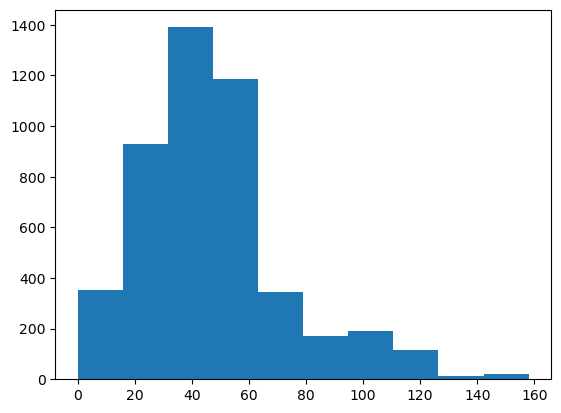

In [28]:
plt.hist([len(v) for k, v in dict_pred.items()])

In [54]:
arr_th = [0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.3]
arr_f1 = []
for th in arr_th:
    dict_pred = tmp.create_predictions(threshold_weighted_labels=th)
    for k in dict_val_species.keys():
        if k not in dict_pred.keys():
            dict_pred[k] = []
    f1 = gpu.compute_f1_score_dicts(dict_val_species, dict_pred)
    arr_f1.append(f1)

  3%|▎         | 294/8892 [00:00<00:05, 1465.25it/s]

No species found for surveyId: 3097
No species found for surveyId: 11260
No species found for surveyId: 29826
No species found for surveyId: 48170
No species found for surveyId: 72970


  7%|▋         | 588/8892 [00:00<00:05, 1440.28it/s]

No species found for surveyId: 169143
No species found for surveyId: 204710
No species found for surveyId: 207047
No species found for surveyId: 207358
No species found for surveyId: 221556
No species found for surveyId: 236244
No species found for surveyId: 252573


 11%|█▏        | 1014/8892 [00:00<00:05, 1353.42it/s]

No species found for surveyId: 390699
No species found for surveyId: 455005


 16%|█▋        | 1457/8892 [00:01<00:05, 1427.68it/s]

No species found for surveyId: 513869
No species found for surveyId: 522260
No species found for surveyId: 534650
No species found for surveyId: 547062
No species found for surveyId: 623026
No species found for surveyId: 629043
No species found for surveyId: 633054


 20%|█▉        | 1742/8892 [00:01<00:05, 1395.27it/s]

No species found for surveyId: 678058
No species found for surveyId: 700959
No species found for surveyId: 708353
No species found for surveyId: 715880
No species found for surveyId: 722429
No species found for surveyId: 724208
No species found for surveyId: 732799


 24%|██▍       | 2167/8892 [00:01<00:04, 1407.00it/s]

No species found for surveyId: 880303
No species found for surveyId: 882970
No species found for surveyId: 893006
No species found for surveyId: 982201


 28%|██▊       | 2454/8892 [00:01<00:04, 1377.51it/s]

No species found for surveyId: 1014046
No species found for surveyId: 1109501
No species found for surveyId: 1131001


 32%|███▏      | 2885/8892 [00:02<00:04, 1415.74it/s]

No species found for surveyId: 1168885
No species found for surveyId: 1186325
No species found for surveyId: 1215524
No species found for surveyId: 1239557


 36%|███▌      | 3167/8892 [00:02<00:04, 1374.44it/s]

No species found for surveyId: 1305951
No species found for surveyId: 1365261
No species found for surveyId: 1408094
No species found for surveyId: 1419423


 41%|████      | 3602/8892 [00:02<00:03, 1422.03it/s]

No species found for surveyId: 1471451
No species found for surveyId: 1491916
No species found for surveyId: 1564358
No species found for surveyId: 1589018
No species found for surveyId: 1590220


 44%|████▎     | 3890/8892 [00:02<00:03, 1397.34it/s]

No species found for surveyId: 1644403
No species found for surveyId: 1703156
No species found for surveyId: 1708077
No species found for surveyId: 1726611
No species found for surveyId: 1745501
No species found for surveyId: 1773372


 49%|████▊     | 4321/8892 [00:03<00:03, 1414.55it/s]

No species found for surveyId: 1804460
No species found for surveyId: 1809912
No species found for surveyId: 1810751
No species found for surveyId: 1861020
No species found for surveyId: 1885054
No species found for surveyId: 1895205
No species found for surveyId: 1896156
No species found for surveyId: 1926677


 52%|█████▏    | 4602/8892 [00:03<00:03, 1366.92it/s]

No species found for surveyId: 1944998
No species found for surveyId: 1948917
No species found for surveyId: 1983340
No species found for surveyId: 2045771
No species found for surveyId: 2089469


 57%|█████▋    | 5042/8892 [00:03<00:02, 1434.69it/s]

No species found for surveyId: 2117412
No species found for surveyId: 2158677
No species found for surveyId: 2166684
No species found for surveyId: 2189206


 60%|█████▉    | 5329/8892 [00:03<00:02, 1415.56it/s]

No species found for surveyId: 2250539
No species found for surveyId: 2259700
No species found for surveyId: 2275358
No species found for surveyId: 2305705
No species found for surveyId: 2367679


 65%|██████▌   | 5781/8892 [00:04<00:02, 1475.70it/s]

No species found for surveyId: 2425626
No species found for surveyId: 2463675
No species found for surveyId: 2467890
No species found for surveyId: 2470854
No species found for surveyId: 2496860
No species found for surveyId: 2497140
No species found for surveyId: 2506268
No species found for surveyId: 2517371
No species found for surveyId: 2527847


 68%|██████▊   | 6074/8892 [00:04<00:01, 1432.20it/s]

No species found for surveyId: 2585877
No species found for surveyId: 2630590
No species found for surveyId: 2641258
No species found for surveyId: 2643368
No species found for surveyId: 2654260
No species found for surveyId: 2667227
No species found for surveyId: 2673761


 72%|███████▏  | 6360/8892 [00:04<00:01, 1414.11it/s]

No species found for surveyId: 2713272
No species found for surveyId: 2729558
No species found for surveyId: 2729965


 76%|███████▋  | 6792/8892 [00:04<00:01, 1419.76it/s]

No species found for surveyId: 2896145
No species found for surveyId: 2926475
No species found for surveyId: 2931679
No species found for surveyId: 2934552
No species found for surveyId: 2939121
No species found for surveyId: 2969942
No species found for surveyId: 2990607
No species found for surveyId: 3028015


 80%|███████▉  | 7088/8892 [00:05<00:01, 1446.82it/s]

No species found for surveyId: 3036794
No species found for surveyId: 3037670
No species found for surveyId: 3042071
No species found for surveyId: 3051691
No species found for surveyId: 3059468
No species found for surveyId: 3063820
No species found for surveyId: 3075593
No species found for surveyId: 3077240
No species found for surveyId: 3089408
No species found for surveyId: 3101281
No species found for surveyId: 3127573


 85%|████████▍ | 7521/8892 [00:05<00:00, 1424.61it/s]

No species found for surveyId: 3198443
No species found for surveyId: 3204245
No species found for surveyId: 3208363
No species found for surveyId: 3217167
No species found for surveyId: 3230316
No species found for surveyId: 3293413


 89%|████████▉ | 7948/8892 [00:05<00:00, 1385.30it/s]

No species found for surveyId: 3370256
No species found for surveyId: 3371790
No species found for surveyId: 3434471
No species found for surveyId: 3445790
No species found for surveyId: 3462982
No species found for surveyId: 3470788


 94%|█████████▍| 8389/8892 [00:05<00:00, 1437.81it/s]

No species found for surveyId: 3583662
No species found for surveyId: 3584106
No species found for surveyId: 3605493
No species found for surveyId: 3624224
No species found for surveyId: 3720791
No species found for surveyId: 3721722


 98%|█████████▊| 8677/8892 [00:06<00:00, 1341.95it/s]

No species found for surveyId: 3755139
No species found for surveyId: 3808998
No species found for surveyId: 3819929
No species found for surveyId: 3847472


100%|██████████| 8892/8892 [00:06<00:00, 1405.56it/s]


No species found for surveyId: 3894839
Predictions done. No species found: 137/8892.


  3%|▎         | 295/8892 [00:00<00:05, 1476.16it/s]

No species found for surveyId: 3097
No species found for surveyId: 11260
No species found for surveyId: 29826
No species found for surveyId: 48170
No species found for surveyId: 72970


  7%|▋         | 593/8892 [00:00<00:05, 1463.99it/s]

No species found for surveyId: 169143
No species found for surveyId: 204710
No species found for surveyId: 207047
No species found for surveyId: 207358
No species found for surveyId: 221556
No species found for surveyId: 236244
No species found for surveyId: 252573


 12%|█▏        | 1029/8892 [00:00<00:05, 1425.13it/s]

No species found for surveyId: 390699
No species found for surveyId: 455005


 15%|█▍        | 1328/8892 [00:00<00:05, 1462.46it/s]

No species found for surveyId: 513869
No species found for surveyId: 522260
No species found for surveyId: 534650
No species found for surveyId: 547062
No species found for surveyId: 623026
No species found for surveyId: 629043
No species found for surveyId: 633054


 20%|█▉        | 1764/8892 [00:01<00:04, 1427.06it/s]

No species found for surveyId: 678058
No species found for surveyId: 700959
No species found for surveyId: 708353
No species found for surveyId: 715880
No species found for surveyId: 722429
No species found for surveyId: 724208
No species found for surveyId: 732799


 25%|██▍       | 2194/8892 [00:01<00:04, 1416.19it/s]

No species found for surveyId: 880303
No species found for surveyId: 882970
No species found for surveyId: 893006
No species found for surveyId: 982201


 28%|██▊       | 2479/8892 [00:01<00:04, 1386.88it/s]

No species found for surveyId: 1014046
No species found for surveyId: 1109501
No species found for surveyId: 1131001


 33%|███▎      | 2908/8892 [00:02<00:04, 1414.00it/s]

No species found for surveyId: 1168885
No species found for surveyId: 1186325
No species found for surveyId: 1215524
No species found for surveyId: 1239557


 36%|███▌      | 3190/8892 [00:02<00:04, 1386.81it/s]

No species found for surveyId: 1305951
No species found for surveyId: 1365261
No species found for surveyId: 1408094
No species found for surveyId: 1419423


 41%|████      | 3625/8892 [00:02<00:03, 1402.79it/s]

No species found for surveyId: 1471451
No species found for surveyId: 1491916
No species found for surveyId: 1564358
No species found for surveyId: 1589018
No species found for surveyId: 1590220


 44%|████▍     | 3914/8892 [00:02<00:03, 1421.16it/s]

No species found for surveyId: 1644403
No species found for surveyId: 1703156
No species found for surveyId: 1708077
No species found for surveyId: 1726611
No species found for surveyId: 1745501
No species found for surveyId: 1773372


 49%|████▉     | 4351/8892 [00:03<00:03, 1434.44it/s]

No species found for surveyId: 1804460
No species found for surveyId: 1809912
No species found for surveyId: 1810751
No species found for surveyId: 1861020
No species found for surveyId: 1885054
No species found for surveyId: 1895205
No species found for surveyId: 1896156
No species found for surveyId: 1926677


 52%|█████▏    | 4643/8892 [00:03<00:02, 1435.56it/s]

No species found for surveyId: 1944998
No species found for surveyId: 1948917
No species found for surveyId: 1983340
No species found for surveyId: 2045771


 56%|█████▌    | 4940/8892 [00:03<00:02, 1459.73it/s]

No species found for surveyId: 2089469
No species found for surveyId: 2117412
No species found for surveyId: 2158677
No species found for surveyId: 2166684
No species found for surveyId: 2189206


 60%|██████    | 5379/8892 [00:03<00:02, 1443.69it/s]

No species found for surveyId: 2250539
No species found for surveyId: 2259700
No species found for surveyId: 2275358
No species found for surveyId: 2305705
No species found for surveyId: 2367679


 64%|██████▍   | 5678/8892 [00:03<00:02, 1466.90it/s]

No species found for surveyId: 2425626
No species found for surveyId: 2463675
No species found for surveyId: 2467890
No species found for surveyId: 2470854
No species found for surveyId: 2496860
No species found for surveyId: 2497140
No species found for surveyId: 2506268
No species found for surveyId: 2517371
No species found for surveyId: 2527847


 69%|██████▉   | 6123/8892 [00:04<00:01, 1459.84it/s]

No species found for surveyId: 2585877
No species found for surveyId: 2630590
No species found for surveyId: 2641258
No species found for surveyId: 2643368
No species found for surveyId: 2654260
No species found for surveyId: 2667227
No species found for surveyId: 2673761


 72%|███████▏  | 6417/8892 [00:04<00:01, 1453.03it/s]

No species found for surveyId: 2713272
No species found for surveyId: 2729558
No species found for surveyId: 2729965


 77%|███████▋  | 6856/8892 [00:04<00:01, 1437.71it/s]

No species found for surveyId: 2896145
No species found for surveyId: 2926475
No species found for surveyId: 2931679
No species found for surveyId: 2934552
No species found for surveyId: 2939121
No species found for surveyId: 2969942
No species found for surveyId: 2990607
No species found for surveyId: 3028015


 80%|████████  | 7151/8892 [00:04<00:01, 1451.45it/s]

No species found for surveyId: 3036794
No species found for surveyId: 3037670
No species found for surveyId: 3042071
No species found for surveyId: 3051691
No species found for surveyId: 3059468
No species found for surveyId: 3063820
No species found for surveyId: 3075593
No species found for surveyId: 3077240
No species found for surveyId: 3089408
No species found for surveyId: 3101281
No species found for surveyId: 3127573


 85%|████████▌ | 7582/8892 [00:05<00:00, 1395.31it/s]

No species found for surveyId: 3198443
No species found for surveyId: 3204245
No species found for surveyId: 3208363
No species found for surveyId: 3217167
No species found for surveyId: 3230316
No species found for surveyId: 3293413


 88%|████████▊ | 7865/8892 [00:05<00:00, 1397.76it/s]

No species found for surveyId: 3370256
No species found for surveyId: 3371790
No species found for surveyId: 3434471
No species found for surveyId: 3445790
No species found for surveyId: 3462982
No species found for surveyId: 3470788


 95%|█████████▌| 8449/8892 [00:05<00:00, 1444.11it/s]

No species found for surveyId: 3583662
No species found for surveyId: 3584106
No species found for surveyId: 3605493
No species found for surveyId: 3624224
No species found for surveyId: 3720791
No species found for surveyId: 3721722


 98%|█████████▊| 8736/8892 [00:06<00:00, 1417.41it/s]

No species found for surveyId: 3755139
No species found for surveyId: 3808998
No species found for surveyId: 3819929
No species found for surveyId: 3847472


100%|██████████| 8892/8892 [00:06<00:00, 1423.54it/s]


No species found for surveyId: 3894839
Predictions done. No species found: 137/8892.


  3%|▎         | 296/8892 [00:00<00:05, 1483.10it/s]

No species found for surveyId: 3097
No species found for surveyId: 11260
No species found for surveyId: 29826
No species found for surveyId: 48170
No species found for surveyId: 72970


  7%|▋         | 594/8892 [00:00<00:05, 1471.37it/s]

No species found for surveyId: 169143
No species found for surveyId: 204710
No species found for surveyId: 207047
No species found for surveyId: 207358
No species found for surveyId: 221556
No species found for surveyId: 236244
No species found for surveyId: 252573


 12%|█▏        | 1032/8892 [00:00<00:05, 1438.32it/s]

No species found for surveyId: 390699
No species found for surveyId: 455005


 17%|█▋        | 1470/8892 [00:01<00:05, 1411.65it/s]

No species found for surveyId: 513869
No species found for surveyId: 522260
No species found for surveyId: 534650
No species found for surveyId: 547062
No species found for surveyId: 623026
No species found for surveyId: 629043
No species found for surveyId: 633054


 20%|█▉        | 1760/8892 [00:01<00:04, 1431.41it/s]

No species found for surveyId: 678058
No species found for surveyId: 700959
No species found for surveyId: 708353
No species found for surveyId: 715880
No species found for surveyId: 722429
No species found for surveyId: 724208
No species found for surveyId: 732799


 25%|██▍       | 2196/8892 [00:01<00:04, 1416.70it/s]

No species found for surveyId: 880303
No species found for surveyId: 882970
No species found for surveyId: 893006
No species found for surveyId: 982201


 28%|██▊       | 2484/8892 [00:01<00:04, 1387.75it/s]

No species found for surveyId: 1014046
No species found for surveyId: 1109501
No species found for surveyId: 1131001


 33%|███▎      | 2912/8892 [00:02<00:04, 1409.79it/s]

No species found for surveyId: 1168885
No species found for surveyId: 1186325
No species found for surveyId: 1215524
No species found for surveyId: 1239557


 36%|███▌      | 3194/8892 [00:02<00:04, 1391.49it/s]

No species found for surveyId: 1305951
No species found for surveyId: 1365261
No species found for surveyId: 1408094
No species found for surveyId: 1419423


 41%|████      | 3629/8892 [00:02<00:03, 1428.61it/s]

No species found for surveyId: 1471451
No species found for surveyId: 1491916
No species found for surveyId: 1564358
No species found for surveyId: 1589018
No species found for surveyId: 1590220


 44%|████▍     | 3921/8892 [00:02<00:03, 1441.71it/s]

No species found for surveyId: 1644403
No species found for surveyId: 1703156
No species found for surveyId: 1708077
No species found for surveyId: 1726611
No species found for surveyId: 1745501
No species found for surveyId: 1773372


 49%|████▉     | 4358/8892 [00:03<00:03, 1441.86it/s]

No species found for surveyId: 1804460
No species found for surveyId: 1809912
No species found for surveyId: 1810751
No species found for surveyId: 1861020
No species found for surveyId: 1885054
No species found for surveyId: 1895205
No species found for surveyId: 1896156
No species found for surveyId: 1926677


 52%|█████▏    | 4649/8892 [00:03<00:02, 1444.19it/s]

No species found for surveyId: 1944998
No species found for surveyId: 1948917
No species found for surveyId: 1983340
No species found for surveyId: 2045771


 56%|█████▌    | 4944/8892 [00:03<00:02, 1459.15it/s]

No species found for surveyId: 2089469
No species found for surveyId: 2117412
No species found for surveyId: 2158677
No species found for surveyId: 2166684
No species found for surveyId: 2189206


 59%|█████▉    | 5233/8892 [00:03<00:02, 1377.47it/s]

No species found for surveyId: 2250539
No species found for surveyId: 2259700
No species found for surveyId: 2275358
No species found for surveyId: 2305705
No species found for surveyId: 2367679


 64%|██████▍   | 5676/8892 [00:03<00:02, 1446.67it/s]

No species found for surveyId: 2425626
No species found for surveyId: 2463675
No species found for surveyId: 2467890
No species found for surveyId: 2470854
No species found for surveyId: 2496860
No species found for surveyId: 2497140
No species found for surveyId: 2506268
No species found for surveyId: 2517371
No species found for surveyId: 2527847


 69%|██████▉   | 6121/8892 [00:04<00:01, 1459.07it/s]

No species found for surveyId: 2585877
No species found for surveyId: 2630590
No species found for surveyId: 2641258
No species found for surveyId: 2643368
No species found for surveyId: 2654260
No species found for surveyId: 2667227
No species found for surveyId: 2673761
No species found for surveyId: 2713272


 72%|███████▏  | 6419/8892 [00:04<00:01, 1458.34it/s]

No species found for surveyId: 2729558
No species found for surveyId: 2729965


 77%|███████▋  | 6860/8892 [00:04<00:01, 1449.44it/s]

No species found for surveyId: 2896145
No species found for surveyId: 2926475
No species found for surveyId: 2931679
No species found for surveyId: 2934552
No species found for surveyId: 2939121
No species found for surveyId: 2969942
No species found for surveyId: 2990607
No species found for surveyId: 3028015


 80%|████████  | 7152/8892 [00:05<00:01, 1452.07it/s]

No species found for surveyId: 3036794
No species found for surveyId: 3037670
No species found for surveyId: 3042071
No species found for surveyId: 3051691
No species found for surveyId: 3059468
No species found for surveyId: 3063820
No species found for surveyId: 3075593
No species found for surveyId: 3077240
No species found for surveyId: 3089408
No species found for surveyId: 3101281
No species found for surveyId: 3127573


 85%|████████▌ | 7594/8892 [00:05<00:00, 1449.97it/s]

No species found for surveyId: 3198443
No species found for surveyId: 3204245
No species found for surveyId: 3208363
No species found for surveyId: 3217167
No species found for surveyId: 3230316
No species found for surveyId: 3293413


 89%|████████▊ | 7885/8892 [00:05<00:00, 1419.86it/s]

No species found for surveyId: 3370256
No species found for surveyId: 3371790
No species found for surveyId: 3434471
No species found for surveyId: 3445790
No species found for surveyId: 3462982
No species found for surveyId: 3470788


 94%|█████████▎| 8325/8892 [00:05<00:00, 1441.77it/s]

No species found for surveyId: 3583662
No species found for surveyId: 3584106
No species found for surveyId: 3605493
No species found for surveyId: 3624224
No species found for surveyId: 3720791
No species found for surveyId: 3721722


 99%|█████████▊| 8765/8892 [00:06<00:00, 1444.48it/s]

No species found for surveyId: 3755139
No species found for surveyId: 3808998
No species found for surveyId: 3819929
No species found for surveyId: 3847472


100%|██████████| 8892/8892 [00:06<00:00, 1431.14it/s]


No species found for surveyId: 3894839
Predictions done. No species found: 137/8892.


  3%|▎         | 299/8892 [00:00<00:05, 1492.31it/s]

No species found for surveyId: 3097
No species found for surveyId: 11260
No species found for surveyId: 29826
No species found for surveyId: 48170
No species found for surveyId: 72970


  7%|▋         | 601/8892 [00:00<00:05, 1480.88it/s]

No species found for surveyId: 169143
No species found for surveyId: 204710
No species found for surveyId: 207047
No species found for surveyId: 207358
No species found for surveyId: 221556
No species found for surveyId: 236244
No species found for surveyId: 252573


 12%|█▏        | 1042/8892 [00:00<00:05, 1446.55it/s]

No species found for surveyId: 390699
No species found for surveyId: 455005


 15%|█▌        | 1334/8892 [00:00<00:05, 1441.54it/s]

No species found for surveyId: 513869
No species found for surveyId: 522260
No species found for surveyId: 534650
No species found for surveyId: 547062
No species found for surveyId: 623026
No species found for surveyId: 629043
No species found for surveyId: 633054


 20%|█▉        | 1773/8892 [00:01<00:04, 1449.25it/s]

No species found for surveyId: 678058
No species found for surveyId: 700959
No species found for surveyId: 708353
No species found for surveyId: 715880
No species found for surveyId: 722429
No species found for surveyId: 724208
No species found for surveyId: 732799


 25%|██▍       | 2210/8892 [00:01<00:04, 1430.06it/s]

No species found for surveyId: 880303
No species found for surveyId: 882970
No species found for surveyId: 893006
No species found for surveyId: 982201


 28%|██▊       | 2497/8892 [00:01<00:04, 1391.84it/s]

No species found for surveyId: 1014046
No species found for surveyId: 1109501
No species found for surveyId: 1131001


 33%|███▎      | 2924/8892 [00:02<00:04, 1405.18it/s]

No species found for surveyId: 1168885
No species found for surveyId: 1186325
No species found for surveyId: 1215524
No species found for surveyId: 1239557


 36%|███▌      | 3205/8892 [00:02<00:04, 1389.44it/s]

No species found for surveyId: 1305951
No species found for surveyId: 1365261
No species found for surveyId: 1408094
No species found for surveyId: 1419423


 41%|████      | 3643/8892 [00:02<00:03, 1433.43it/s]

No species found for surveyId: 1471451
No species found for surveyId: 1491916
No species found for surveyId: 1564358
No species found for surveyId: 1589018
No species found for surveyId: 1590220


 44%|████▍     | 3931/8892 [00:02<00:03, 1396.29it/s]

No species found for surveyId: 1644403
No species found for surveyId: 1703156
No species found for surveyId: 1708077
No species found for surveyId: 1726611
No species found for surveyId: 1745501
No species found for surveyId: 1773372


 49%|████▉     | 4361/8892 [00:03<00:03, 1415.34it/s]

No species found for surveyId: 1804460
No species found for surveyId: 1809912
No species found for surveyId: 1810751
No species found for surveyId: 1861020
No species found for surveyId: 1885054
No species found for surveyId: 1895205
No species found for surveyId: 1896156
No species found for surveyId: 1926677


 52%|█████▏    | 4653/8892 [00:03<00:02, 1430.12it/s]

No species found for surveyId: 1944998
No species found for surveyId: 1948917
No species found for surveyId: 1983340
No species found for surveyId: 2045771


 56%|█████▌    | 4946/8892 [00:03<00:02, 1448.73it/s]

No species found for surveyId: 2089469
No species found for surveyId: 2117412
No species found for surveyId: 2158677
No species found for surveyId: 2166684
No species found for surveyId: 2189206


 59%|█████▉    | 5240/8892 [00:03<00:02, 1445.01it/s]

No species found for surveyId: 2250539
No species found for surveyId: 2259700
No species found for surveyId: 2275358
No species found for surveyId: 2305705
No species found for surveyId: 2367679


 64%|██████▍   | 5683/8892 [00:03<00:02, 1464.58it/s]

No species found for surveyId: 2425626
No species found for surveyId: 2463675
No species found for surveyId: 2467890
No species found for surveyId: 2470854
No species found for surveyId: 2496860
No species found for surveyId: 2497140
No species found for surveyId: 2506268
No species found for surveyId: 2517371
No species found for surveyId: 2527847


 69%|██████▉   | 6133/8892 [00:04<00:01, 1462.42it/s]

No species found for surveyId: 2585877
No species found for surveyId: 2630590
No species found for surveyId: 2641258
No species found for surveyId: 2643368
No species found for surveyId: 2654260
No species found for surveyId: 2667227
No species found for surveyId: 2673761


 72%|███████▏  | 6425/8892 [00:04<00:01, 1440.67it/s]

No species found for surveyId: 2713272
No species found for surveyId: 2729558
No species found for surveyId: 2729965


 77%|███████▋  | 6865/8892 [00:04<00:01, 1448.07it/s]

No species found for surveyId: 2896145
No species found for surveyId: 2926475
No species found for surveyId: 2931679
No species found for surveyId: 2934552
No species found for surveyId: 2939121
No species found for surveyId: 2969942
No species found for surveyId: 2990607
No species found for surveyId: 3028015


 81%|████████  | 7164/8892 [00:04<00:01, 1472.09it/s]

No species found for surveyId: 3036794
No species found for surveyId: 3037670
No species found for surveyId: 3042071
No species found for surveyId: 3051691
No species found for surveyId: 3059468
No species found for surveyId: 3063820
No species found for surveyId: 3075593
No species found for surveyId: 3077240
No species found for surveyId: 3089408
No species found for surveyId: 3101281
No species found for surveyId: 3127573


 84%|████████▍ | 7458/8892 [00:05<00:00, 1437.10it/s]

No species found for surveyId: 3198443
No species found for surveyId: 3204245
No species found for surveyId: 3208363
No species found for surveyId: 3217167
No species found for surveyId: 3230316
No species found for surveyId: 3293413


 89%|████████▊ | 7888/8892 [00:05<00:00, 1384.47it/s]

No species found for surveyId: 3370256
No species found for surveyId: 3371790
No species found for surveyId: 3434471
No species found for surveyId: 3445790
No species found for surveyId: 3462982
No species found for surveyId: 3470788


 94%|█████████▎| 8332/8892 [00:05<00:00, 1449.61it/s]

No species found for surveyId: 3583662
No species found for surveyId: 3584106
No species found for surveyId: 3605493
No species found for surveyId: 3624224
No species found for surveyId: 3720791
No species found for surveyId: 3721722


 99%|█████████▊| 8773/8892 [00:06<00:00, 1442.61it/s]

No species found for surveyId: 3755139
No species found for surveyId: 3808998
No species found for surveyId: 3819929
No species found for surveyId: 3847472


100%|██████████| 8892/8892 [00:06<00:00, 1432.37it/s]


No species found for surveyId: 3894839
Predictions done. No species found: 137/8892.


  3%|▎         | 297/8892 [00:00<00:05, 1483.39it/s]

No species found for surveyId: 3097
No species found for surveyId: 11260
No species found for surveyId: 29826
No species found for surveyId: 48170
No species found for surveyId: 72970


  7%|▋         | 594/8892 [00:00<00:05, 1469.44it/s]

No species found for surveyId: 169143
No species found for surveyId: 204710
No species found for surveyId: 207047
No species found for surveyId: 207358
No species found for surveyId: 221556
No species found for surveyId: 236244
No species found for surveyId: 252573


 12%|█▏        | 1033/8892 [00:00<00:05, 1442.13it/s]

No species found for surveyId: 390699
No species found for surveyId: 455005


 17%|█▋        | 1479/8892 [00:01<00:05, 1451.03it/s]

No species found for surveyId: 513869
No species found for surveyId: 522260
No species found for surveyId: 534650
No species found for surveyId: 547062
No species found for surveyId: 623026
No species found for surveyId: 629043
No species found for surveyId: 633054


 20%|█▉        | 1770/8892 [00:01<00:04, 1439.35it/s]

No species found for surveyId: 678058
No species found for surveyId: 700959
No species found for surveyId: 708353
No species found for surveyId: 715880
No species found for surveyId: 722429
No species found for surveyId: 724208
No species found for surveyId: 732799


 25%|██▍       | 2205/8892 [00:01<00:04, 1422.98it/s]

No species found for surveyId: 880303
No species found for surveyId: 882970
No species found for surveyId: 893006
No species found for surveyId: 982201


 28%|██▊       | 2492/8892 [00:01<00:04, 1358.93it/s]

No species found for surveyId: 1014046
No species found for surveyId: 1109501
No species found for surveyId: 1131001


 33%|███▎      | 2921/8892 [00:02<00:04, 1402.12it/s]

No species found for surveyId: 1168885
No species found for surveyId: 1186325
No species found for surveyId: 1215524
No species found for surveyId: 1239557


 36%|███▌      | 3201/8892 [00:02<00:04, 1385.37it/s]

No species found for surveyId: 1305951
No species found for surveyId: 1365261
No species found for surveyId: 1408094
No species found for surveyId: 1419423


 41%|████      | 3638/8892 [00:02<00:03, 1428.10it/s]

No species found for surveyId: 1471451
No species found for surveyId: 1491916
No species found for surveyId: 1564358
No species found for surveyId: 1589018
No species found for surveyId: 1590220


 44%|████▍     | 3929/8892 [00:02<00:03, 1434.59it/s]

No species found for surveyId: 1644403
No species found for surveyId: 1703156
No species found for surveyId: 1708077
No species found for surveyId: 1726611
No species found for surveyId: 1745501
No species found for surveyId: 1773372


 49%|████▉     | 4367/8892 [00:03<00:03, 1441.98it/s]

No species found for surveyId: 1804460
No species found for surveyId: 1809912
No species found for surveyId: 1810751
No species found for surveyId: 1861020
No species found for surveyId: 1885054
No species found for surveyId: 1895205
No species found for surveyId: 1896156
No species found for surveyId: 1926677


 52%|█████▏    | 4661/8892 [00:03<00:02, 1447.69it/s]

No species found for surveyId: 1944998
No species found for surveyId: 1948917
No species found for surveyId: 1983340
No species found for surveyId: 2045771


 56%|█████▌    | 4956/8892 [00:03<00:02, 1459.59it/s]

No species found for surveyId: 2089469
No species found for surveyId: 2117412
No species found for surveyId: 2158677
No species found for surveyId: 2166684
No species found for surveyId: 2189206


 59%|█████▉    | 5251/8892 [00:03<00:02, 1454.37it/s]

No species found for surveyId: 2250539
No species found for surveyId: 2259700
No species found for surveyId: 2275358
No species found for surveyId: 2305705
No species found for surveyId: 2367679


 64%|██████▍   | 5701/8892 [00:03<00:02, 1482.35it/s]

No species found for surveyId: 2425626
No species found for surveyId: 2463675
No species found for surveyId: 2467890
No species found for surveyId: 2470854
No species found for surveyId: 2496860
No species found for surveyId: 2497140
No species found for surveyId: 2506268
No species found for surveyId: 2517371
No species found for surveyId: 2527847


 69%|██████▉   | 6142/8892 [00:04<00:01, 1403.08it/s]

No species found for surveyId: 2585877
No species found for surveyId: 2630590
No species found for surveyId: 2641258
No species found for surveyId: 2643368
No species found for surveyId: 2654260
No species found for surveyId: 2667227
No species found for surveyId: 2673761


 72%|███████▏  | 6434/8892 [00:04<00:01, 1429.36it/s]

No species found for surveyId: 2713272
No species found for surveyId: 2729558
No species found for surveyId: 2729965


 77%|███████▋  | 6869/8892 [00:04<00:01, 1428.57it/s]

No species found for surveyId: 2896145
No species found for surveyId: 2926475
No species found for surveyId: 2931679
No species found for surveyId: 2934552
No species found for surveyId: 2939121
No species found for surveyId: 2969942
No species found for surveyId: 2990607
No species found for surveyId: 3028015
No species found for surveyId: 3036794
No species found for surveyId: 3037670


 81%|████████  | 7162/8892 [00:05<00:01, 1442.95it/s]

No species found for surveyId: 3042071
No species found for surveyId: 3051691
No species found for surveyId: 3059468
No species found for surveyId: 3063820
No species found for surveyId: 3075593
No species found for surveyId: 3077240
No species found for surveyId: 3089408
No species found for surveyId: 3101281
No species found for surveyId: 3127573


 85%|████████▌ | 7597/8892 [00:05<00:00, 1438.20it/s]

No species found for surveyId: 3198443
No species found for surveyId: 3204245
No species found for surveyId: 3208363
No species found for surveyId: 3217167
No species found for surveyId: 3230316
No species found for surveyId: 3293413


 89%|████████▊ | 7885/8892 [00:05<00:00, 1422.32it/s]

No species found for surveyId: 3370256
No species found for surveyId: 3371790
No species found for surveyId: 3434471
No species found for surveyId: 3445790
No species found for surveyId: 3462982
No species found for surveyId: 3470788


 95%|█████████▌| 8473/8892 [00:05<00:00, 1452.86it/s]

No species found for surveyId: 3583662
No species found for surveyId: 3584106
No species found for surveyId: 3605493
No species found for surveyId: 3624224
No species found for surveyId: 3720791
No species found for surveyId: 3721722


 99%|█████████▊| 8764/8892 [00:06<00:00, 1440.49it/s]

No species found for surveyId: 3755139
No species found for surveyId: 3808998
No species found for surveyId: 3819929
No species found for surveyId: 3847472


100%|██████████| 8892/8892 [00:06<00:00, 1432.31it/s]


No species found for surveyId: 3894839
Predictions done. No species found: 137/8892.


  3%|▎         | 296/8892 [00:00<00:05, 1479.70it/s]

No species found for surveyId: 3097
No species found for surveyId: 11260
No species found for surveyId: 29826
No species found for surveyId: 48170
No species found for surveyId: 72970


  7%|▋         | 592/8892 [00:00<00:05, 1411.60it/s]

No species found for surveyId: 169143
No species found for surveyId: 204710
No species found for surveyId: 207047
No species found for surveyId: 207358
No species found for surveyId: 221556
No species found for surveyId: 236244
No species found for surveyId: 252573


 11%|█▏        | 1021/8892 [00:00<00:05, 1407.44it/s]

No species found for surveyId: 390699
No species found for surveyId: 455005


 17%|█▋        | 1470/8892 [00:01<00:05, 1439.56it/s]

No species found for surveyId: 513869
No species found for surveyId: 522260
No species found for surveyId: 534650
No species found for surveyId: 547062
No species found for surveyId: 623026
No species found for surveyId: 629043
No species found for surveyId: 633054


 20%|█▉        | 1758/8892 [00:01<00:05, 1414.32it/s]

No species found for surveyId: 678058
No species found for surveyId: 700959
No species found for surveyId: 708353
No species found for surveyId: 715880
No species found for surveyId: 722429
No species found for surveyId: 724208
No species found for surveyId: 732799


 25%|██▍       | 2189/8892 [00:01<00:04, 1408.78it/s]

No species found for surveyId: 880303
No species found for surveyId: 882970
No species found for surveyId: 893006
No species found for surveyId: 982201


 28%|██▊       | 2471/8892 [00:01<00:04, 1371.90it/s]

No species found for surveyId: 1014046
No species found for surveyId: 1109501
No species found for surveyId: 1131001


 33%|███▎      | 2900/8892 [00:02<00:04, 1402.41it/s]

No species found for surveyId: 1168885
No species found for surveyId: 1186325
No species found for surveyId: 1215524
No species found for surveyId: 1239557


 36%|███▌      | 3181/8892 [00:02<00:04, 1383.15it/s]

No species found for surveyId: 1305951
No species found for surveyId: 1365261
No species found for surveyId: 1408094
No species found for surveyId: 1419423


 41%|████      | 3624/8892 [00:02<00:03, 1441.85it/s]

No species found for surveyId: 1471451
No species found for surveyId: 1491916
No species found for surveyId: 1564358
No species found for surveyId: 1589018
No species found for surveyId: 1590220


 44%|████▍     | 3913/8892 [00:02<00:03, 1426.38it/s]

No species found for surveyId: 1644403
No species found for surveyId: 1703156
No species found for surveyId: 1708077
No species found for surveyId: 1726611
No species found for surveyId: 1745501
No species found for surveyId: 1773372


 49%|████▉     | 4350/8892 [00:03<00:03, 1401.92it/s]

No species found for surveyId: 1804460
No species found for surveyId: 1809912
No species found for surveyId: 1810751
No species found for surveyId: 1861020
No species found for surveyId: 1885054
No species found for surveyId: 1895205
No species found for surveyId: 1896156
No species found for surveyId: 1926677


 52%|█████▏    | 4641/8892 [00:03<00:03, 1412.25it/s]

No species found for surveyId: 1944998
No species found for surveyId: 1948917
No species found for surveyId: 1983340
No species found for surveyId: 2045771


 56%|█████▌    | 4936/8892 [00:03<00:02, 1439.25it/s]

No species found for surveyId: 2089469
No species found for surveyId: 2117412
No species found for surveyId: 2158677
No species found for surveyId: 2166684
No species found for surveyId: 2189206


 60%|██████    | 5370/8892 [00:03<00:02, 1421.72it/s]

No species found for surveyId: 2250539
No species found for surveyId: 2259700
No species found for surveyId: 2275358
No species found for surveyId: 2305705
No species found for surveyId: 2367679


 64%|██████▍   | 5671/8892 [00:03<00:02, 1462.72it/s]

No species found for surveyId: 2425626
No species found for surveyId: 2463675
No species found for surveyId: 2467890
No species found for surveyId: 2470854
No species found for surveyId: 2496860
No species found for surveyId: 2497140
No species found for surveyId: 2506268
No species found for surveyId: 2517371
No species found for surveyId: 2527847


 69%|██████▉   | 6122/8892 [00:04<00:01, 1469.32it/s]

No species found for surveyId: 2585877
No species found for surveyId: 2630590
No species found for surveyId: 2641258
No species found for surveyId: 2643368
No species found for surveyId: 2654260
No species found for surveyId: 2667227
No species found for surveyId: 2673761


 72%|███████▏  | 6417/8892 [00:04<00:01, 1464.69it/s]

No species found for surveyId: 2713272
No species found for surveyId: 2729558
No species found for surveyId: 2729965


 77%|███████▋  | 6858/8892 [00:04<00:01, 1441.16it/s]

No species found for surveyId: 2896145
No species found for surveyId: 2926475
No species found for surveyId: 2931679
No species found for surveyId: 2934552
No species found for surveyId: 2939121
No species found for surveyId: 2969942
No species found for surveyId: 2990607
No species found for surveyId: 3028015
No species found for surveyId: 3036794
No species found for surveyId: 3037670


 80%|████████  | 7153/8892 [00:05<00:01, 1453.83it/s]

No species found for surveyId: 3042071
No species found for surveyId: 3051691
No species found for surveyId: 3059468
No species found for surveyId: 3063820
No species found for surveyId: 3075593
No species found for surveyId: 3077240
No species found for surveyId: 3089408
No species found for surveyId: 3101281
No species found for surveyId: 3127573


 85%|████████▌ | 7592/8892 [00:05<00:00, 1442.64it/s]

No species found for surveyId: 3198443
No species found for surveyId: 3204245
No species found for surveyId: 3208363
No species found for surveyId: 3217167
No species found for surveyId: 3230316
No species found for surveyId: 3293413


 89%|████████▊ | 7877/8892 [00:05<00:00, 1381.03it/s]

No species found for surveyId: 3370256
No species found for surveyId: 3371790
No species found for surveyId: 3434471
No species found for surveyId: 3445790
No species found for surveyId: 3462982
No species found for surveyId: 3470788


 95%|█████████▌| 8466/8892 [00:05<00:00, 1451.82it/s]

No species found for surveyId: 3583662
No species found for surveyId: 3584106
No species found for surveyId: 3605493
No species found for surveyId: 3624224
No species found for surveyId: 3720791
No species found for surveyId: 3721722


 98%|█████████▊| 8758/8892 [00:06<00:00, 1435.55it/s]

No species found for surveyId: 3755139
No species found for surveyId: 3808998
No species found for surveyId: 3819929
No species found for surveyId: 3847472


100%|██████████| 8892/8892 [00:06<00:00, 1423.20it/s]


No species found for surveyId: 3894839
Predictions done. No species found: 137/8892.


  3%|▎         | 297/8892 [00:00<00:05, 1485.66it/s]

No species found for surveyId: 3097
No species found for surveyId: 11260
No species found for surveyId: 29826
No species found for surveyId: 48170
No species found for surveyId: 72970


  7%|▋         | 594/8892 [00:00<00:05, 1463.72it/s]

No species found for surveyId: 169143
No species found for surveyId: 204710
No species found for surveyId: 207047
No species found for surveyId: 207358
No species found for surveyId: 221556
No species found for surveyId: 236244
No species found for surveyId: 252573


 12%|█▏        | 1031/8892 [00:00<00:05, 1432.04it/s]

No species found for surveyId: 390699
No species found for surveyId: 455005


 15%|█▍        | 1329/8892 [00:00<00:05, 1457.27it/s]

No species found for surveyId: 513869
No species found for surveyId: 522260
No species found for surveyId: 534650
No species found for surveyId: 547062
No species found for surveyId: 623026
No species found for surveyId: 629043
No species found for surveyId: 633054


 20%|█▉        | 1768/8892 [00:01<00:04, 1458.21it/s]

No species found for surveyId: 678058
No species found for surveyId: 700959
No species found for surveyId: 708353
No species found for surveyId: 715880
No species found for surveyId: 722429
No species found for surveyId: 724208
No species found for surveyId: 732799


 25%|██▍       | 2206/8892 [00:01<00:04, 1444.27it/s]

No species found for surveyId: 880303
No species found for surveyId: 882970
No species found for surveyId: 893006
No species found for surveyId: 982201
No species found for surveyId: 1014046


 31%|███▏      | 2796/8892 [00:01<00:04, 1410.08it/s]

No species found for surveyId: 1109501
No species found for surveyId: 1131001
No species found for surveyId: 1168885
No species found for surveyId: 1186325
No species found for surveyId: 1215524
No species found for surveyId: 1239557


 36%|███▌      | 3223/8892 [00:02<00:04, 1399.25it/s]

No species found for surveyId: 1305951
No species found for surveyId: 1365261
No species found for surveyId: 1408094
No species found for surveyId: 1419423


 40%|███▉      | 3523/8892 [00:02<00:03, 1446.41it/s]

No species found for surveyId: 1471451
No species found for surveyId: 1491916
No species found for surveyId: 1564358
No species found for surveyId: 1589018
No species found for surveyId: 1590220


 45%|████▍     | 3978/8892 [00:02<00:03, 1458.33it/s]

No species found for surveyId: 1644403
No species found for surveyId: 1703156
No species found for surveyId: 1708077
No species found for surveyId: 1726611
No species found for surveyId: 1745501
No species found for surveyId: 1773372


 48%|████▊     | 4266/8892 [00:02<00:03, 1373.43it/s]

No species found for surveyId: 1804460
No species found for surveyId: 1809912
No species found for surveyId: 1810751
No species found for surveyId: 1861020
No species found for surveyId: 1885054
No species found for surveyId: 1895205
No species found for surveyId: 1896156
No species found for surveyId: 1926677


 51%|█████     | 4547/8892 [00:03<00:03, 1378.08it/s]

No species found for surveyId: 1944998
No species found for surveyId: 1948917
No species found for surveyId: 1983340
No species found for surveyId: 2045771


 56%|█████▌    | 4992/8892 [00:03<00:02, 1452.79it/s]

No species found for surveyId: 2089469
No species found for surveyId: 2117412
No species found for surveyId: 2158677
No species found for surveyId: 2166684
No species found for surveyId: 2189206


 59%|█████▉    | 5286/8892 [00:03<00:02, 1457.76it/s]

No species found for surveyId: 2250539
No species found for surveyId: 2259700
No species found for surveyId: 2275358
No species found for surveyId: 2305705
No species found for surveyId: 2367679


 65%|██████▍   | 5754/8892 [00:03<00:02, 1528.23it/s]

No species found for surveyId: 2425626
No species found for surveyId: 2463675
No species found for surveyId: 2467890
No species found for surveyId: 2470854
No species found for surveyId: 2496860
No species found for surveyId: 2497140
No species found for surveyId: 2506268
No species found for surveyId: 2517371
No species found for surveyId: 2527847


 68%|██████▊   | 6059/8892 [00:04<00:01, 1487.04it/s]

No species found for surveyId: 2585877
No species found for surveyId: 2630590
No species found for surveyId: 2641258
No species found for surveyId: 2643368
No species found for surveyId: 2654260
No species found for surveyId: 2667227
No species found for surveyId: 2673761


 71%|███████▏  | 6357/8892 [00:04<00:01, 1407.55it/s]

No species found for surveyId: 2713272
No species found for surveyId: 2729558
No species found for surveyId: 2729965


 76%|███████▋  | 6789/8892 [00:04<00:01, 1424.10it/s]

No species found for surveyId: 2896145
No species found for surveyId: 2926475
No species found for surveyId: 2931679
No species found for surveyId: 2934552
No species found for surveyId: 2939121
No species found for surveyId: 2969942
No species found for surveyId: 2990607
No species found for surveyId: 3028015
No species found for surveyId: 3036794
No species found for surveyId: 3037670


 80%|███████▉  | 7091/8892 [00:04<00:01, 1461.31it/s]

No species found for surveyId: 3042071
No species found for surveyId: 3051691
No species found for surveyId: 3059468
No species found for surveyId: 3063820
No species found for surveyId: 3075593
No species found for surveyId: 3077240
No species found for surveyId: 3089408
No species found for surveyId: 3101281
No species found for surveyId: 3127573


 85%|████████▍ | 7530/8892 [00:05<00:00, 1449.15it/s]

No species found for surveyId: 3198443
No species found for surveyId: 3204245
No species found for surveyId: 3208363
No species found for surveyId: 3217167
No species found for surveyId: 3230316
No species found for surveyId: 3293413


 90%|████████▉ | 7961/8892 [00:05<00:00, 1400.11it/s]

No species found for surveyId: 3370256
No species found for surveyId: 3371790
No species found for surveyId: 3434471
No species found for surveyId: 3445790
No species found for surveyId: 3462982
No species found for surveyId: 3470788


 94%|█████████▍| 8401/8892 [00:05<00:00, 1443.05it/s]

No species found for surveyId: 3583662
No species found for surveyId: 3584106
No species found for surveyId: 3605493
No species found for surveyId: 3624224
No species found for surveyId: 3720791
No species found for surveyId: 3721722


 98%|█████████▊| 8691/8892 [00:06<00:00, 1420.98it/s]

No species found for surveyId: 3755139
No species found for surveyId: 3808998
No species found for surveyId: 3819929
No species found for surveyId: 3847472


100%|██████████| 8892/8892 [00:06<00:00, 1434.25it/s]


No species found for surveyId: 3894839
Predictions done. No species found: 137/8892.


  3%|▎         | 296/8892 [00:00<00:05, 1473.86it/s]

No species found for surveyId: 3097
No species found for surveyId: 4006
No species found for surveyId: 11260
No species found for surveyId: 29826
No species found for surveyId: 41443
No species found for surveyId: 48170
No species found for surveyId: 72970
No species found for surveyId: 76017
No species found for surveyId: 84865
No species found for surveyId: 124041


  7%|▋         | 589/8892 [00:00<00:05, 1429.11it/s]

No species found for surveyId: 169143
No species found for surveyId: 192770
No species found for surveyId: 204710
No species found for surveyId: 207047
No species found for surveyId: 207358
No species found for surveyId: 221556
No species found for surveyId: 236244
No species found for surveyId: 242898
No species found for surveyId: 243614
No species found for surveyId: 252573
No species found for surveyId: 285529
No species found for surveyId: 287494


 10%|▉         | 877/8892 [00:00<00:05, 1416.58it/s]

No species found for surveyId: 316708
No species found for surveyId: 335145
No species found for surveyId: 345900
No species found for surveyId: 365655
No species found for surveyId: 369126
No species found for surveyId: 381759
No species found for surveyId: 382872
No species found for surveyId: 385247
No species found for surveyId: 390699
No species found for surveyId: 407114


 15%|█▍        | 1322/8892 [00:00<00:05, 1467.07it/s]

No species found for surveyId: 455005
No species found for surveyId: 478623
No species found for surveyId: 503266
No species found for surveyId: 513869
No species found for surveyId: 522260
No species found for surveyId: 532446
No species found for surveyId: 534650
No species found for surveyId: 547062


 18%|█▊        | 1614/8892 [00:01<00:05, 1439.31it/s]

No species found for surveyId: 599163
No species found for surveyId: 623026
No species found for surveyId: 629043
No species found for surveyId: 633054
No species found for surveyId: 675502
No species found for surveyId: 678058
No species found for surveyId: 700959
No species found for surveyId: 704031
No species found for surveyId: 708353
No species found for surveyId: 715880
No species found for surveyId: 722429
No species found for surveyId: 724208


 21%|██▏       | 1900/8892 [00:01<00:05, 1377.23it/s]

No species found for surveyId: 732799
No species found for surveyId: 748853
No species found for surveyId: 750615
No species found for surveyId: 829376


 24%|██▍       | 2176/8892 [00:01<00:04, 1349.78it/s]

No species found for surveyId: 862593
No species found for surveyId: 880303
No species found for surveyId: 881195
No species found for surveyId: 882970
No species found for surveyId: 893006
No species found for surveyId: 893737
No species found for surveyId: 910121
No species found for surveyId: 930552
No species found for surveyId: 964079
No species found for surveyId: 964789


 27%|██▋       | 2440/8892 [00:01<00:05, 1250.21it/s]

No species found for surveyId: 975477
No species found for surveyId: 982201
No species found for surveyId: 1014046
No species found for surveyId: 1025952
No species found for surveyId: 1030246
No species found for surveyId: 1082537
No species found for surveyId: 1092301


 31%|███       | 2719/8892 [00:01<00:04, 1323.46it/s]

No species found for surveyId: 1109501
No species found for surveyId: 1128652
No species found for surveyId: 1131001
No species found for surveyId: 1150392
No species found for surveyId: 1152488
No species found for surveyId: 1168885
No species found for surveyId: 1177659
No species found for surveyId: 1186325
No species found for surveyId: 1213021
No species found for surveyId: 1215524
No species found for surveyId: 1220086


 34%|███▍      | 3006/8892 [00:02<00:04, 1359.83it/s]

No species found for surveyId: 1236920
No species found for surveyId: 1239557
No species found for surveyId: 1244567
No species found for surveyId: 1277973
No species found for surveyId: 1299352
No species found for surveyId: 1305951


 37%|███▋      | 3284/8892 [00:02<00:04, 1369.99it/s]

No species found for surveyId: 1346199
No species found for surveyId: 1365261
No species found for surveyId: 1396969
No species found for surveyId: 1408094
No species found for surveyId: 1419423
No species found for surveyId: 1471451
No species found for surveyId: 1476444


 40%|████      | 3575/8892 [00:02<00:03, 1339.16it/s]

No species found for surveyId: 1491916
No species found for surveyId: 1527886
No species found for surveyId: 1548184
No species found for surveyId: 1564358
No species found for surveyId: 1577925
No species found for surveyId: 1589018
No species found for surveyId: 1590220
No species found for surveyId: 1603578


 45%|████▌     | 4012/8892 [00:02<00:03, 1411.27it/s]

No species found for surveyId: 1644403
No species found for surveyId: 1660704
No species found for surveyId: 1671859
No species found for surveyId: 1673988
No species found for surveyId: 1674320
No species found for surveyId: 1703156
No species found for surveyId: 1708077
No species found for surveyId: 1726611
No species found for surveyId: 1732478
No species found for surveyId: 1745501
No species found for surveyId: 1773372


 48%|████▊     | 4299/8892 [00:03<00:03, 1415.49it/s]

No species found for surveyId: 1794026
No species found for surveyId: 1798633
No species found for surveyId: 1804460
No species found for surveyId: 1809912
No species found for surveyId: 1810751
No species found for surveyId: 1861020
No species found for surveyId: 1867378
No species found for surveyId: 1885054
No species found for surveyId: 1895205
No species found for surveyId: 1896156
No species found for surveyId: 1926677


 52%|█████▏    | 4591/8892 [00:03<00:02, 1435.67it/s]

No species found for surveyId: 1939109
No species found for surveyId: 1944998
No species found for surveyId: 1945432
No species found for surveyId: 1948917
No species found for surveyId: 1964667
No species found for surveyId: 1983340
No species found for surveyId: 2045771
No species found for surveyId: 2048099
No species found for surveyId: 2064079
No species found for surveyId: 2077349


 55%|█████▍    | 4885/8892 [00:03<00:02, 1453.93it/s]

No species found for surveyId: 2089469
No species found for surveyId: 2095452
No species found for surveyId: 2117412
No species found for surveyId: 2158677
No species found for surveyId: 2166684
No species found for surveyId: 2176331
No species found for surveyId: 2178628
No species found for surveyId: 2189206
No species found for surveyId: 2193331


 58%|█████▊    | 5182/8892 [00:03<00:02, 1441.72it/s]

No species found for surveyId: 2219977
No species found for surveyId: 2237450
No species found for surveyId: 2242415
No species found for surveyId: 2250539
No species found for surveyId: 2250811
No species found for surveyId: 2259700
No species found for surveyId: 2275358
No species found for surveyId: 2297729
No species found for surveyId: 2297860
No species found for surveyId: 2305705
No species found for surveyId: 2332688
No species found for surveyId: 2337984


 63%|██████▎   | 5628/8892 [00:04<00:02, 1473.57it/s]

No species found for surveyId: 2354201
No species found for surveyId: 2367679
No species found for surveyId: 2425626
No species found for surveyId: 2442433
No species found for surveyId: 2444067
No species found for surveyId: 2461357
No species found for surveyId: 2463675
No species found for surveyId: 2467890
No species found for surveyId: 2470854


 67%|██████▋   | 5925/8892 [00:04<00:02, 1474.29it/s]

No species found for surveyId: 2496860
No species found for surveyId: 2497140
No species found for surveyId: 2506268
No species found for surveyId: 2511901
No species found for surveyId: 2517371
No species found for surveyId: 2527847
No species found for surveyId: 2585877
No species found for surveyId: 2628334
No species found for surveyId: 2630590


 70%|██████▉   | 6219/8892 [00:04<00:01, 1449.24it/s]

No species found for surveyId: 2641258
No species found for surveyId: 2643368
No species found for surveyId: 2654260
No species found for surveyId: 2667227
No species found for surveyId: 2673761
No species found for surveyId: 2682455
No species found for surveyId: 2693273
No species found for surveyId: 2695630
No species found for surveyId: 2709082
No species found for surveyId: 2713272
No species found for surveyId: 2729558
No species found for surveyId: 2729965
No species found for surveyId: 2760678


 75%|███████▍  | 6660/8892 [00:04<00:01, 1428.90it/s]

No species found for surveyId: 2809026
No species found for surveyId: 2849105
No species found for surveyId: 2870348
No species found for surveyId: 2883087
No species found for surveyId: 2896145
No species found for surveyId: 2926475
No species found for surveyId: 2928501
No species found for surveyId: 2931679
No species found for surveyId: 2934552


 78%|███████▊  | 6953/8892 [00:04<00:01, 1432.61it/s]

No species found for surveyId: 2939121
No species found for surveyId: 2969942
No species found for surveyId: 2990607
No species found for surveyId: 3028015
No species found for surveyId: 3036794
No species found for surveyId: 3037670
No species found for surveyId: 3042071
No species found for surveyId: 3046286
No species found for surveyId: 3051691
No species found for surveyId: 3059468
No species found for surveyId: 3063820


 81%|████████▏ | 7244/8892 [00:05<00:01, 1440.33it/s]

No species found for surveyId: 3075593
No species found for surveyId: 3077240
No species found for surveyId: 3089408
No species found for surveyId: 3101281
No species found for surveyId: 3117791
No species found for surveyId: 3127573
No species found for surveyId: 3166443
No species found for surveyId: 3182718
No species found for surveyId: 3185426


 85%|████████▍ | 7535/8892 [00:05<00:00, 1446.04it/s]

No species found for surveyId: 3198443
No species found for surveyId: 3202538
No species found for surveyId: 3204245
No species found for surveyId: 3208363
No species found for surveyId: 3217167
No species found for surveyId: 3227307
No species found for surveyId: 3230316
No species found for surveyId: 3282226
No species found for surveyId: 3293413
No species found for surveyId: 3295725
No species found for surveyId: 3301136


 88%|████████▊ | 7823/8892 [00:05<00:00, 1417.65it/s]

No species found for surveyId: 3350935
No species found for surveyId: 3370256
No species found for surveyId: 3371790
No species found for surveyId: 3415889
No species found for surveyId: 3434471
No species found for surveyId: 3437921
No species found for surveyId: 3443597
No species found for surveyId: 3445790
No species found for surveyId: 3462982
No species found for surveyId: 3470788


 93%|█████████▎| 8261/8892 [00:05<00:00, 1443.06it/s]

No species found for surveyId: 3532913
No species found for surveyId: 3583662
No species found for surveyId: 3584106
No species found for surveyId: 3605493
No species found for surveyId: 3624224
No species found for surveyId: 3695738


 96%|█████████▌| 8552/8892 [00:06<00:00, 1447.74it/s]

No species found for surveyId: 3712275
No species found for surveyId: 3714727
No species found for surveyId: 3720791
No species found for surveyId: 3721722
No species found for surveyId: 3733901
No species found for surveyId: 3755139
No species found for surveyId: 3763390
No species found for surveyId: 3766829
No species found for surveyId: 3788606
No species found for surveyId: 3791622
No species found for surveyId: 3803234
No species found for surveyId: 3808998
No species found for surveyId: 3813053
No species found for surveyId: 3819929


100%|██████████| 8892/8892 [00:06<00:00, 1413.96it/s]


No species found for surveyId: 3847472
No species found for surveyId: 3894839
Predictions done. No species found: 261/8892.


In [55]:
print('F1 scores 20 km:')
for th, f1 in zip(arr_th, arr_f1):
    print(f'Th: {th}, F1: {f1}')

F1 scores 20 km:
Th: 0.01, F1: 0.17815909998542828
Th: 0.03, F1: 0.22171562850602888
Th: 0.05, F1: 0.2550898257417876
Th: 0.07, F1: 0.2813144225923728
Th: 0.1, F1: 0.31055241911795095
Th: 0.15, F1: 0.33787610690510994
Th: 0.2, F1: 0.34126959671664947
Th: 0.3, F1: 0.29877385480062507


In [51]:
for th, f1 in zip(arr_th, arr_f1):
    print(f'Th: {th}, F1: {f1}')

Th: 0.01, F1: 0.1993253455507175
Th: 0.03, F1: 0.2339567857022029
Th: 0.05, F1: 0.26306820509513906
Th: 0.07, F1: 0.2874202966047946
Th: 0.1, F1: 0.3149615778560888
Th: 0.15, F1: 0.34330129624560624
Th: 0.2, F1: 0.35171820741153903
Th: 0.3, F1: 0.32425812748704147
